In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import climlab
import pandas as pd
import heating_rates_module as hrm

/Users/wgblumbe/miniconda3/envs/Spring24/lib/python3.10/site-packages/climlab/convection/akmaev_adjustment.py:142: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  Akmaev_adjustment = jit(signature_or_function=Akmaev_adjustment)
/Users/wgblumbe/miniconda3/envs/Spring24/lib/python3.10/site-packages/typhon/nonlte/rtc/__init__.py:9: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for 

# RRTMG Sandbox

This notebook allows you to run the Rapid Radiative Transfer Model that has been optimized to run in General Circulation Models (RRTMG).  This model was developed by the Atmospheric and Environmental Research (AER) group in Lexington, Massachusetts.  It is used widely across the globe by a variety of atmospheric science organizations for example, the ECMWF, the National Centers for Environmental Prediction, the National Center for Atmosphere Research, NASA Goddard Space Flight Center, and many others.  More information on the RRTMG can be found [here](http://rtweb.aer.com/rrtm_frame.html).

This Jupyter notebook allows, you to read in a comma separated value file that specifies an atmosphere profile.  This CSV file includes fields such as temperature, pressure, height, and trace gas concentrations.  Additionally, through this CSV format one can specify various the relative properties ofliquid and ice clouds and aerosol layers.  Using this notebook well allow you to put these fields into the RTMG and run the model.  the notebook allows you to visualize the radiative heating rates, upwelling, and downwelling fluxes from the shortwave (SW) and longwave (LW) modules of the RRTMG.

Much thanks to Brian Rose (U. Albany) for their development of the [Climate Laboratory Toolkit](https://brian-rose.github.io/ClimateLaboratoryBook/home.html).  Their interface to the RRTMG is what maked coding this notebook significantly less painful than it could have been.

## Step 1: Read in the atmosphere CSV file.

When run the cell below will read in a CSV file that includes the necessary atmosphere properties. Because the CSV file does not include cloud properties (it comes from the FASCODE atmospheres) we have to specify directly and amend the CSV file.  The two lines of code below us both read in the CSV file and the necessary cloud and aerosol related fields.

In [18]:
atmosphere = pd.read_csv('input/midlatitude-summer.csv')
atmosphere = hrm.prep_csv4rrtmg(atmosphere)

#### Adding in Cloud and Aerosol Layers

The cell below provides an example of how to add in a cloud that will impact both the longwave radiation and the shortwave radiation.  For example, the indices 5 to 7 indicates the layer where the cloud should be put.  Larger indices indicate a higher layer in the atmosphere.  

For this cloud, we specify a cloud fraction of one (that is a completely covered sky with clouds), and an optical depth of 1 in both the short wave and the long wave.

Additionally, the below shows how to add an aerosol layer that also absorbs radiation in the short wave and longwave.

In [35]:
### Put a cloud in the profile that can affect both the shortwave and longwave
atmosphere.loc[5:7,'Cloud_Fraction'] = 1
atmosphere.loc[5:7,'SW_Cloud_Tau'] = .1
atmosphere.loc[5:7,'LW_Cloud_Tau'] = .3

### Put an aerosol layer in the profile that can affect both the shortwave and longwave
atmosphere.loc[9:11,'SW_Aerosol_Tau'] = 0.2
atmosphere.loc[9:11,'LW_Aerosol_Tau'] = 0.2

atmosphere.head()

,z,t,p,H2O,O3,N2O,O2,CO2,CH4,CFC11,...,SW_Cloud_Tau,SW_Cloud_SSA,SW_Cloud_Asym,SW_Cloud_FSF,SW_Aerosol_Tau,SW_Aerosol_SSA,SW_Aerosol_Asym,LW_Cloud_Tau,LW_Aerosol_Tau,Cloud_Fraction
0,-0.70917,294.2,110000.0,0.018774,3.019448e-08,3.202700e-07,0.209196,0.00033,0.000002,0,...,0,0,0,0,0,0,0,0,0,0
1,0.00000,294.2,101300.0,0.018774,3.019448e-08,3.202700e-07,0.209196,0.00033,0.000002,0,...,0,0,0,0,0,0,0,0,0,0
2,1.00000,289.7,90200.0,0.013791,3.340039e-08,3.202571e-07,0.209174,0.00033,0.000002,0,...,0,0,0,0,0,0,0,0,0,0
3,2.00000,285.2,80200.0,0.009687,3.696188e-08,3.202250e-07,0.209113,0.00033,0.000002,0,...,0,0,0,0,0,0,0,0,0,0
4,3.00000,279.2,71000.0,0.005989,4.224660e-08,3.202294e-07,0.209143,0.00033,0.000002,0,...,0,0,0,0,0,0,0,0,0,0


### Visualizing the Atmosphere

The below cell when run will generate a plot using the specified atmosphere. This plot allows you to visualize the trace gas concentration profiles, any ice or liquid clouds specified, the cloud and aerosol extinction profiles, the cloud fraction profiles, the cloud and aerosol scattering properties, and atmosphere profile.  It can be used to provide a quick summary of what the atmosphere looks like that is going into the RRTMG. 

/var/folders/51/n1wsvkk55p1dlnwf9sh8t3bw0000gn/T/ipykernel_62478/1625019582.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


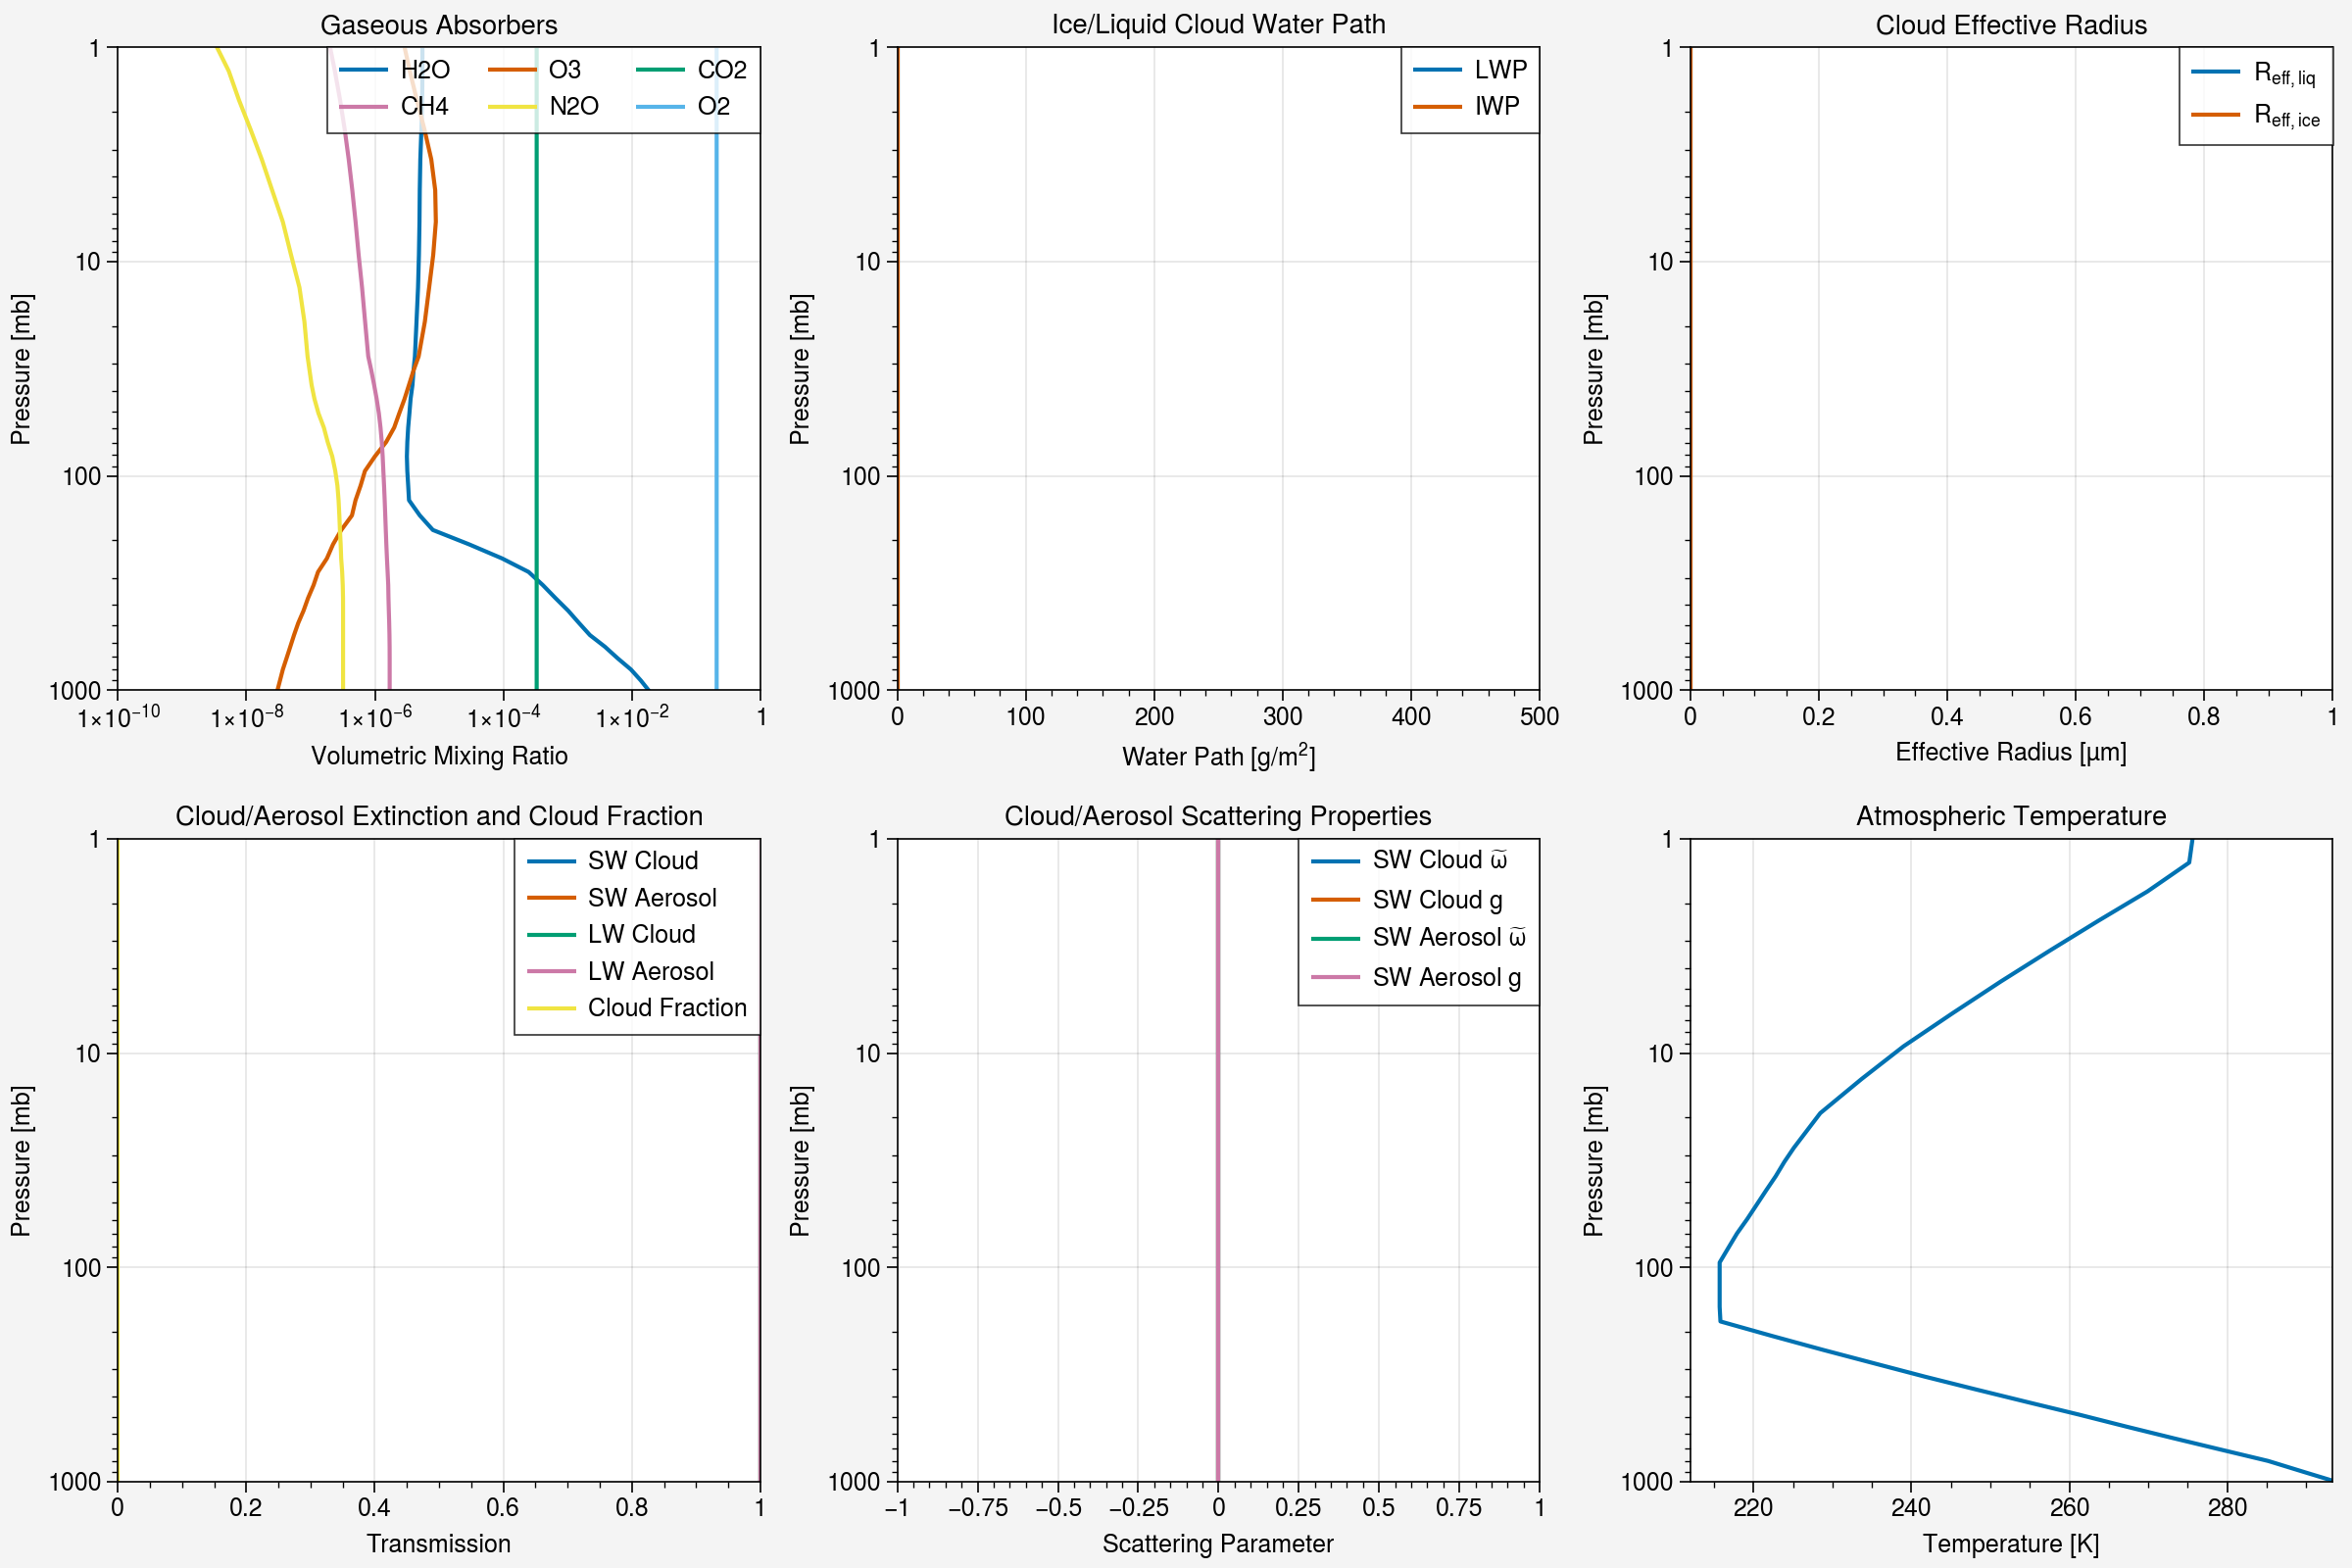

In [36]:
fig = hrm.atmosphere_plotter(atmosphere)
fig.format(ylim=(1000,1))
fig.show()

## Step 2: Prepare dictionaries for the RRTMG function from our atmosphere.

The next step here is to use these helper functions to generate several dictionaries and variables that the RRTMG needs to run.  This code below prepares these for the atmospheric thermodynamics state, any liquid or ice clouds, any aerosol layers, and all of the trace gases.

In [37]:
state = hrm.prep_RRTMG_state(atmosphere)
mycloud = hrm.prep_RRTMG_cloud(atmosphere)
myaerosol = hrm.prep_RRTMG_aerosol(atmosphere)
absorber_vmr, h2ovmr = hrm.prep_RRTMG_absorbers(atmosphere)

## Step 3: Specify the surface properties and solar angle

In the next cell, we set the surface properties such as the emissivity and albedo.  we also specify the solar angle. There are additional parameters that we can use to modify the solar input, but for the purposes of this notebook, they are not included.

In [84]:
# Surface Properties
sfc_emissivity = 0.7
sfc_albedo = 0.3

# Specify the Solar Zenith Angle (90 is directly overhead)
sun_angle = 20

## Step 4: Run the RRTMG

This code block runs the RRTMG and passes the model all of the necessary information to do so.  It also uses the Climate Laboratory package to calculate various diagnostics.

In [85]:
rrtmg = climlab.radiation.RRTMG(state=state, absorber_vmr = absorber_vmr, coszen=np.cos(np.radians(sun_angle)),
                                emissivity=sfc_emissivity, specific_humidity=h2ovmr, albedo=sfc_albedo,
                                return_spectral_olr=True,
                                **mycloud, **myaerosol)
_ = rrtmg.compute_diagnostics()
_ = rrtmg.compute()

## Step 5: Visualize the Output

Once the RRTMG is done running, we can plot the various profiles of radiative heating, as well as the fluxes.  you can use the variables above to set the Y axis limits for this plot.  the plot also includes various numbers at the bottom.  These numbers include the solar constant $S_0$, the outgoing longwave radiation ($OLR$), the absorbed solar radiation ($ASR$), the surface temperature $T_s$, the surface albedo, and the sun angle.  Also included is the datetime stamp from when the RRTMG was run.

### Plot Heating Rates and Flux Profiles

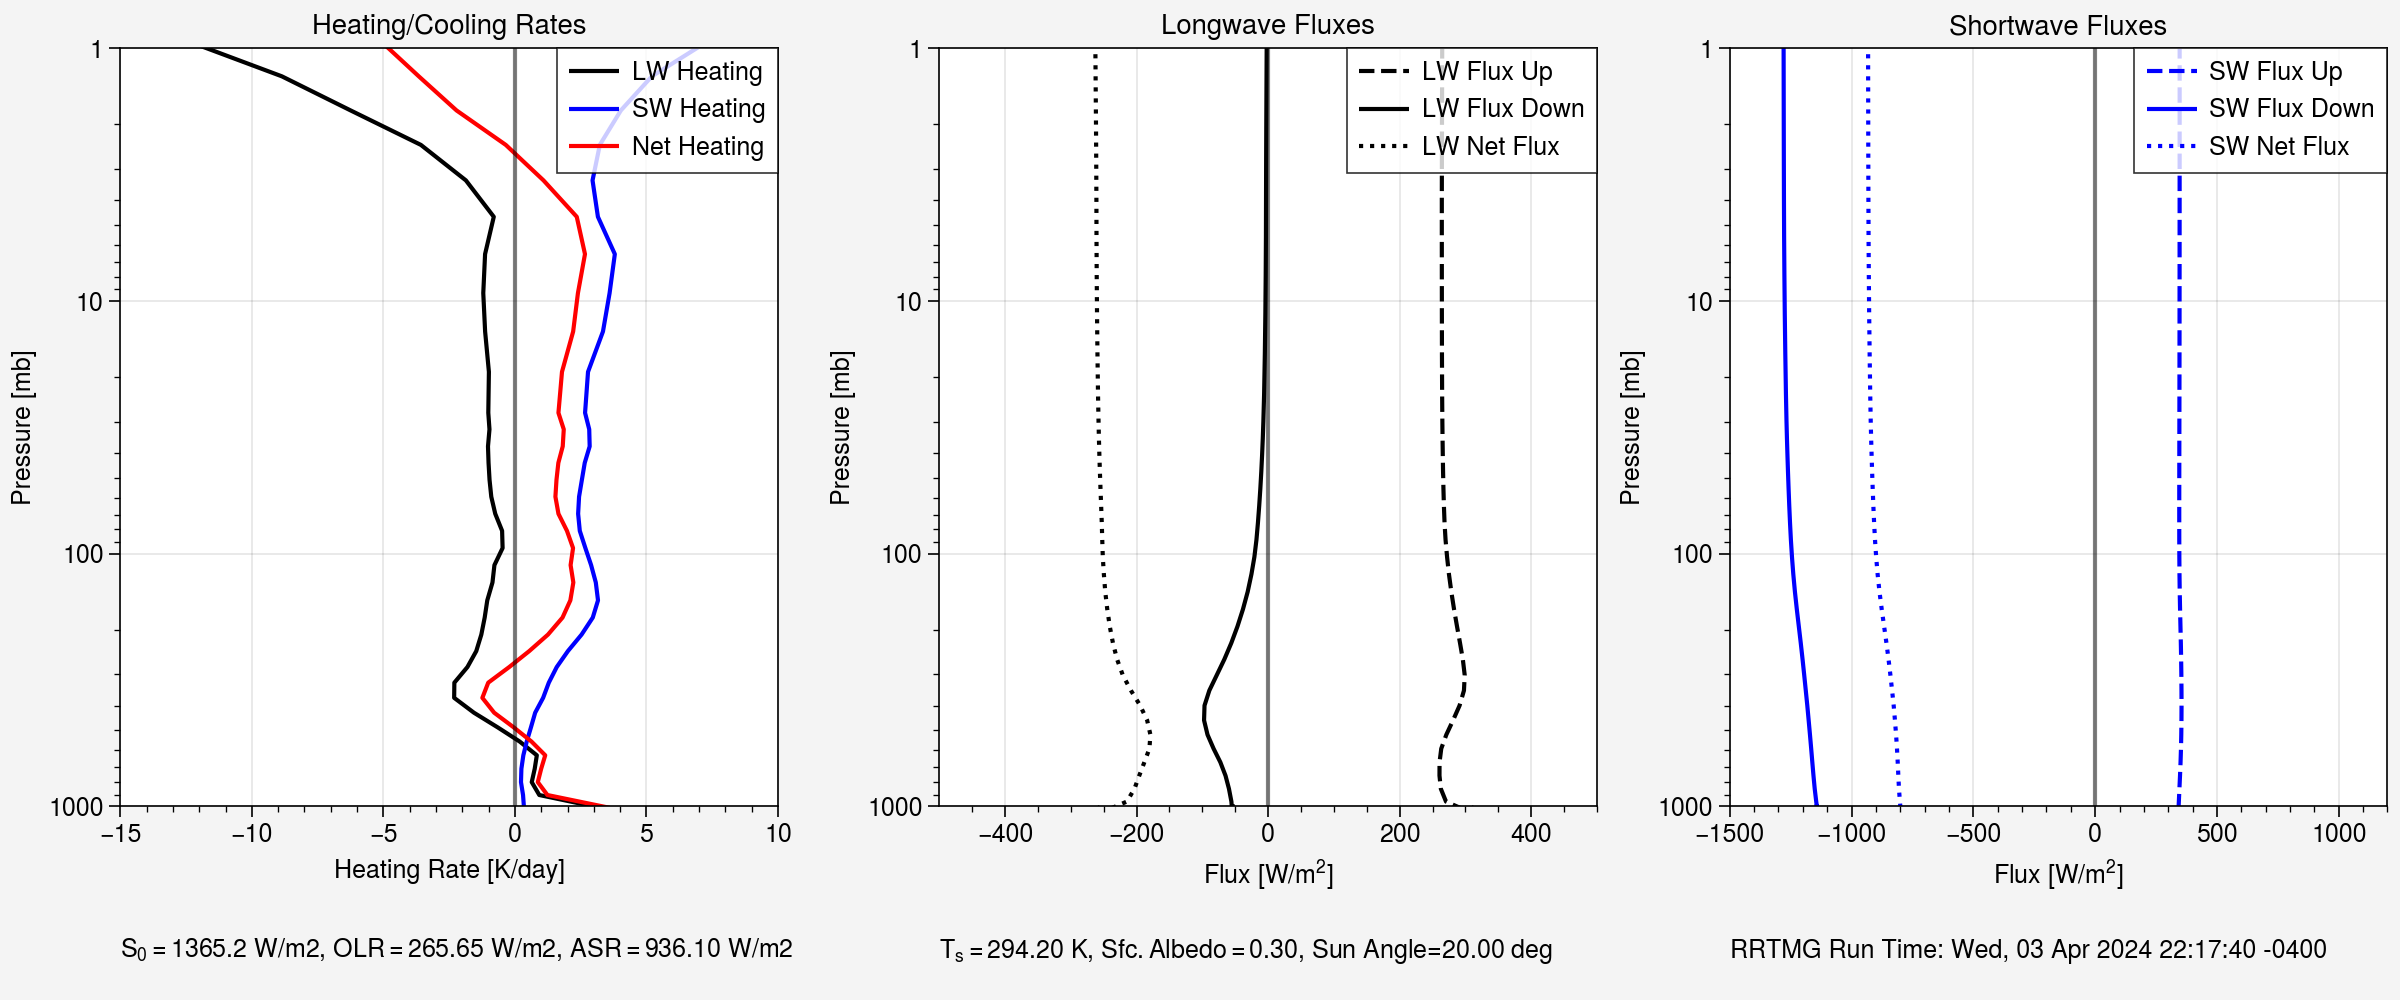

In [86]:
### USE THESE TO ADJUST THE X AND Y-AXIS LIMITS FOR YOUR PLOT
pressure_limits = (1000,1) # mb
hr_limits = (-15, 10) # K/day
flux_limits = (-500,500) # W m^-2
net_flux_limits = (-1500,1200) # W m^-2

hrm.plot_RRTMG(rrtmg, atmosphere, pressure_limits, hr_limits, flux_limits, net_flux_limits)

### Plot Outgoing Longwave Radiation Spectra

The RRTMG also solves for the spectral flux within specified bands.  The Python interface to the RRTMG doesn't allow us to look at all of this output, but we can look at the outgoing, longwave radiation spectra.  The Planck curve for a black body at 268. Kelvin is also plotted as a reference.

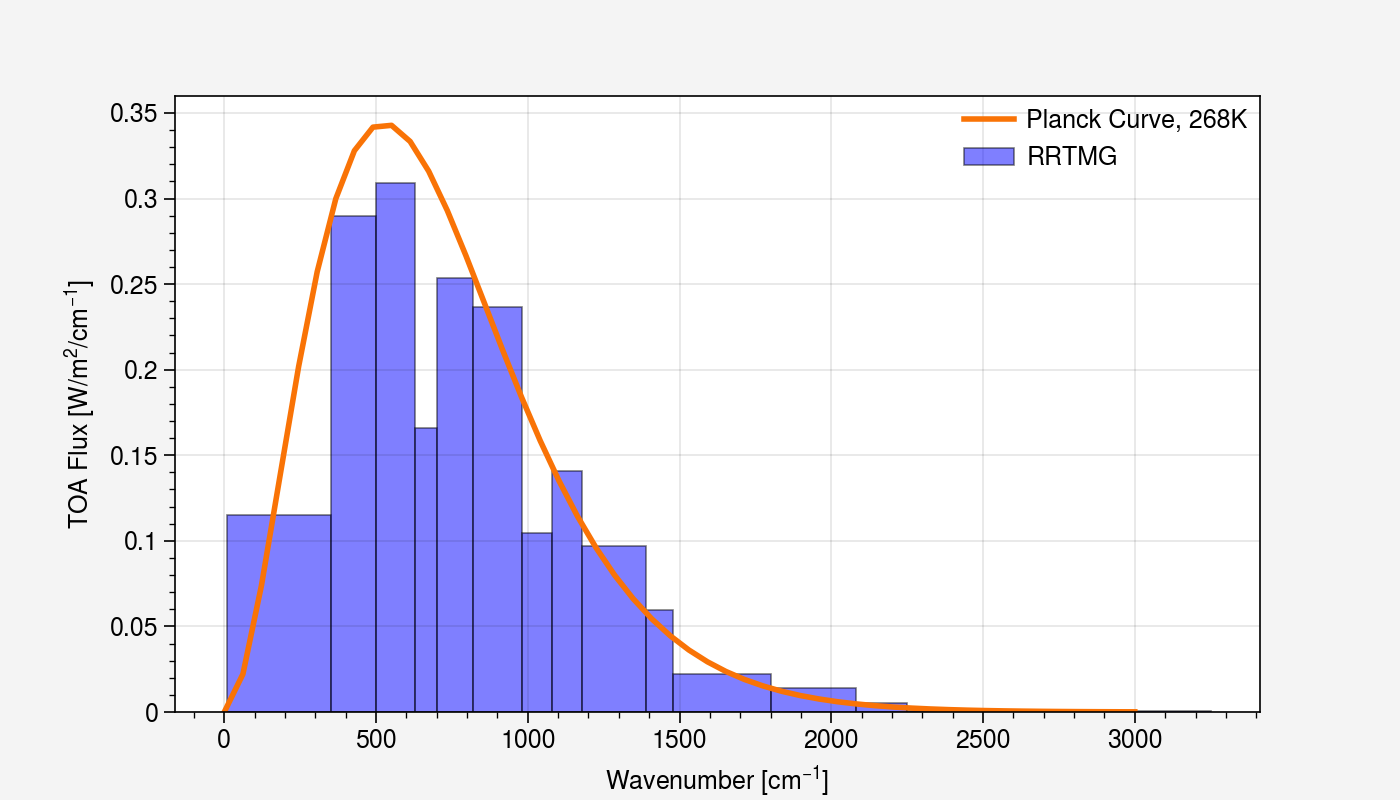

In [88]:
hrm.plot_OLR_Spectra(rrtmg)